In [1]:
!pip install diffusers==0.29.1
!pip install accelerate
!pip install insightface==0.7.3
!pip install onnxruntime
!pip install git+https://github.com/lohiashri/PhotoMaker.git
!git clone https://github.com/lohiashri/PhotoMaker.git
!pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.34.0
    Uninstalling diffusers-0.34.0:
      Successfully uninstalled diffusers-0.34.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
cd PhotoMaker/

[Errno 2] No such file or directory: 'PhotoMaker/'
/kaggle/working/PhotoMaker


In [18]:
import torch
import numpy as np
import random
import os
from PIL import Image

from diffusers.utils import load_image
from diffusers import EulerDiscreteScheduler, DDIMScheduler
from huggingface_hub import hf_hub_download

from photomaker import PhotoMakerStableDiffusionXLPipeline
from photomaker import FaceAnalysis2, analyze_faces

In [21]:
face_detector = FaceAnalysis2(providers=['CUDAExecutionProvider'], allowed_modules=['detection', 'recognition'])
face_detector.prepare(ctx_id=0, det_size=(640, 640))

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:02<00:00, 97542.51KB/s]
/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [9]:
!ls examples/

lenna_woman  pos_ref.png	 statue.png
newton_man   scarletthead_woman  yangmi_woman


In [19]:
# gloal variable and function
def image_grid(imgs, rows, cols, size_after_resize):
    assert len(imgs) == rows*cols

    w, h = size_after_resize, size_after_resize

    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        img = img.resize((w,h))
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

base_model_path = 'SG161222/RealVisXL_V3.0'
device = "cuda"
save_path = "./outputs"

In [12]:
from huggingface_hub import hf_hub_download

photomaker_ckpt = hf_hub_download(repo_id="TencentARC/PhotoMaker-V2", filename="photomaker-v2.bin", repo_type="model")
pipe = PhotoMakerStableDiffusionXLPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.bfloat16,
    use_safetensors=True,
    variant="fp16"
).to(device)

pipe.load_photomaker_adapter(
    os.path.dirname(photomaker_ckpt),
    subfolder="",
    weight_name=os.path.basename(photomaker_ckpt),
    trigger_word="img"
)
pipe.id_encoder.to(device)


#pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
#pipe.fuse_lora()

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
# pipe.set_adapters(["photomaker"], adapter_weights=[1.0])
pipe.fuse_lora()

photomaker-v2.bin:   0%|          | 0.00/1.80G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading PhotoMaker v2 components [1] id_encoder from [/root/.cache/huggingface/hub/models--TencentARC--PhotoMaker-V2/snapshots/f5a1e5155dc02166253fa7e29d13519f5ba22eac]...
4096
Loading PhotoMaker v2 components [2] lora_weights from [/root/.cache/huggingface/hub/models--TencentARC--PhotoMaker-V2/snapshots/f5a1e5155dc02166253fa7e29d13519f5ba22eac]


In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [23]:
# define and show the input ID images
input_folder_name = './examples/scarletthead_woman'
image_basename_list = os.listdir(input_folder_name)
image_path_list = sorted([os.path.join(input_folder_name, basename) for basename in image_basename_list])

input_id_images = []
for image_path in image_path_list:
    input_id_images.append(load_image(image_path))

input_grid = image_grid(input_id_images, 1, 4, size_after_resize=224)

id_embed_list = []

for img in input_id_images:
    img = np.array(img)
    img = img[:, :, ::-1]
    faces = analyze_faces(face_detector, img)
    if len(faces) > 0:
        id_embed_list.append(torch.from_numpy((faces[0]['embedding'])))

if len(id_embed_list) == 0:
    raise ValueError(f"No face detected in input image pool")

id_embeds = torch.stack(id_embed_list)

In [26]:
## Note that the trigger word `img` must follow the class word for personalization
prompt = "portrait photo of a woman img with a cat, colorful, perfect face, best quality"
negative_prompt = "(asymmetry, worst quality, low quality, illustration), open mouth"
generator = torch.Generator(device=device).manual_seed(42)

## Parameter setting
num_steps = 50
style_strength_ratio = 20
start_merge_step = int(float(style_strength_ratio) / 100 * num_steps)
if start_merge_step > 30:
    start_merge_step = 30

images = pipe(
    prompt=prompt,
    input_id_images=input_id_images,
    negative_prompt=negative_prompt,
    id_embeds=id_embeds,
    num_images_per_prompt=1, # Reduced from 4 to 1
    num_inference_steps=num_steps,
    start_merge_step=10,
    generator=generator,
    height=512, # Added to reduce memory usage
    width=512 # Added to reduce memory usage
).images

  0%|          | 0/50 [00:00<?, ?it/s]

Results:


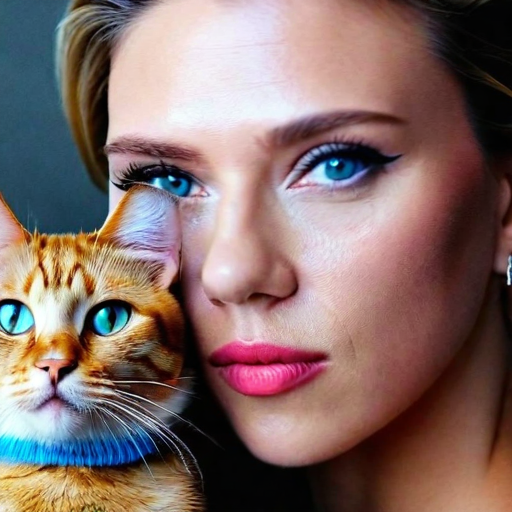

In [27]:
# Show and save the results
## Downsample for visualization
grid = image_grid(images, 1, 1, size_after_resize=512)

os.makedirs(save_path, exist_ok=True)
for idx, image in enumerate(images):
    image.save(os.path.join(save_path, f"photomaker_{idx:02d}.png"))

print("Results:")
grid